## Word-meaning similarity calculation using a hybrid classical-quantum workflow

This notebook will serve to demonstrate a mixed hybrid workflow to examine relationships between words, and respective sentence meanings using classical and quantum information processing techniques.

Our goal is to analyse a corpus, extract key features rom it, and represent those features in a quantum-compatible notation. We proceed to encide these features into a quantum simulation environment using Intel-QS (formerly qHiPSTER), and query for similarities using the encoded quantum states. For this, we have implemented various encoding and analysis strategies. Our primary method for similarity uses a Hamming distance approach, wherein we apply a simplified digital-to-analogue encoding strategy to allow the results to be obtained via measurement.

In [14]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

We must load the Python QNLP packages & module (`QNLP`), and the C++-Python bound simulator backend and algorithms (`PyQNLPSimulator`).

In [15]:
from PyQNLPSimulator import PyQNLPSimulator as p
import QNLP as q
import numpy as np
from QNLP import DisCoCat

from itertools import product
import tempfile

Next, we load the corpus file using the vector-space model, defined in the `VectorSpaceModel` class, specifying the mode of tagging, and whether to filter out stop-words. For this notebook I have used the Project Gutenberg [https://www.gutenberg.org/] edition of `Alice in Wonderland`, with simple replacements to avoid incorrect tagging of elements (mostly standardising apostrophes to \' and quotations to \"). 

In [16]:
vsm = q.VectorSpaceModel.VectorSpaceModel(
    corpus_path="/Users/mlxd/Desktop/qs_dev/intel-qnlp/corpus/11-0.txt", 
    mode=None, 
    stop_words=False
)

From here we can specify the number of basis elements by occurrence in the corpus. This will take the `num_basis_elems` most frequently occurring tokens in both verb and noun spaces respectively.

In [17]:
num_basis_elems = 32
basis     = vsm.define_basis({'verbs' : num_basis_elems, 'nouns' : num_basis_elems})

Next, we aim to sort the mapping of the basis tokens to a binary representation for state encoding. By building a graph, and aiming to solve the TSP problem, we can ensure that the tokens are ordered such that  any nearest-neighbours have the shortest paths. This becomes necessary later when encoding Gray-coded information, as any incorrect bit-flips (potentially offered by noise), should still allow some similarity to be represented. By ordering the tokens by their minimum path lengths we may maintain closeness in the presence of errors.

In [18]:
verb_dist = vsm.sort_basis_tokens_by_dist("verbs", num_basis=num_basis_elems)
noun_dist = vsm.sort_basis_tokens_by_dist("nouns", num_basis=num_basis_elems)

We now take the previously defined basis elements, and attempt to arrange them such that the distance between nearest-neighbours in the corpus is minimised. With this, we assign a Gray code value to the basis. This allows us to ensure values closer together in the corpus have a shorter Hamming distance between them. We make use of the DisCo-inspired compositional model, wherein the distances between words dictates their closeness; we use these distances to define the edge-weights between nodes (tokens), and hence by defining the problem as a TSP, we can find an ordering that ensures Hamming distance relates directly to closeness of words.

In [19]:
vsm.assign_indexing("nouns");
vsm.assign_indexing("verbs");

With the basis tokens correctly ordered, we may now map the other respective elements in their space onto these bases. We aim to map the nouns onto the noun basis, and likewise for the verbs. This allows us to represent any other word in the corpus in the given basis. We may encode arbitrary superposition states to represent the tokens, which can be ascribed as a vector-space representation model using quantum states.

For this, we begin by creating a `DisCoCat` object, and use to perform the mappings of basis tokens.

In [29]:
dcc = DisCoCat.DisCoCat()
mapping_verbs = dcc.map_to_basis(vsm.tokens['verbs'] , noun_dist['verbs'], basis_dist_cutoff=10)
mapping_nouns = dcc.map_to_basis(vsm.tokens['nouns'] , noun_dist['nouns'], basis_dist_cutoff=10)

To ease the understanding of these mapping we may visualise the mapping of items from each space onto their respective bases using a graph/network. We give the <font color='#007FFF'>**blue**</font> coloured nodes as the basis, and the <font color='#008080'>**teal**</font> nodes as the mapped tokens. Edges are drawn between nodes to indicate a relationship, with the edge weight giving the (minimum) distance observed between the tokens in the corpus (mutliple distances may exist, though for simplicity we assume only the minimum).

We now create a graph of the resulting connected entities. The first graph is interactive (pyvis), with the second being static (networkx/matplotlib).

In [30]:
import networkx as nx
g_nouns = nx.graph.Graph()
g_verbs = nx.graph.Graph()

#Add basis words to graph
for v in noun_dist['verbs']:
    g_verbs.add_node(v)
for v in noun_dist['nouns']:
    g_nouns.add_node(v)


In [31]:
# Add mapped/composite words to graph
for i in ["hall", "table"]:#['stocking', 'glove']: #['dawn', 'torrent']:
    g_nouns.add_node(i)

# Set connections between basis and mapped words
    for b_words,b_weights in mapping_nouns[i].items():
        g_nouns.add_edge(i, b_words, weight=b_weights)


In [56]:
#Remove unconnected basis words
uncon = list(nx.isolates(g_nouns))
g_nouns.remove_nodes_from(uncon)

# create diagram positions and edge labels
pos = nx.spring_layout(g_nouns, scale=5.0, k=20/np.sqrt(g_nouns.order())) #nx.bipartite_layout(g_nouns, nx.bipartite.sets(g_nouns)[0], scale=5) #nx.shell_layout(g_nouns, iterations=500)
labels = nx.get_edge_attributes(g_nouns,'weight')

#Colourmap for the nodes
cmap = []
for n in g_nouns:
    if n in noun_dist['nouns']:
        cmap.append('#007FFF')
    else:
        cmap.append('#008080')


In [72]:
############################################################
# Generate interactive graph from pyvis
############################################################
from pyvis.network import Network

G = Network(notebook=True, height="600px", width="100%", bgcolor="#222222", font_color="white")
G.repulsion() # Solver backend
G.show_buttons(filter_=['physics']) # Show sliders to control physics
#G.from_nx(g_nouns)

#Copy across edge weights with distance data
for n_token,n_attr in g_nouns.nodes(data=True):
    if n_token in noun_dist['nouns']:
        G.add_node(n_token, color="#007FFF", **n_attr)
    else:
        G.add_node(n_token, color="#008080", **n_attr)

#Copy across edge weights with distance data
for src,dest,e_attr in g_nouns.edges(data=True):
    G.add_edge(src,dest, width=2, color="#cccacb", title=int(e_attr.get("weight"))) #value=int(e_attr.get("weight")))

G.save_graph("Composite_to_Basis_map_simple1.html")
G.show("Composite_to_Basis_map_simple.html")

<IPython.core.display.Javascript object>


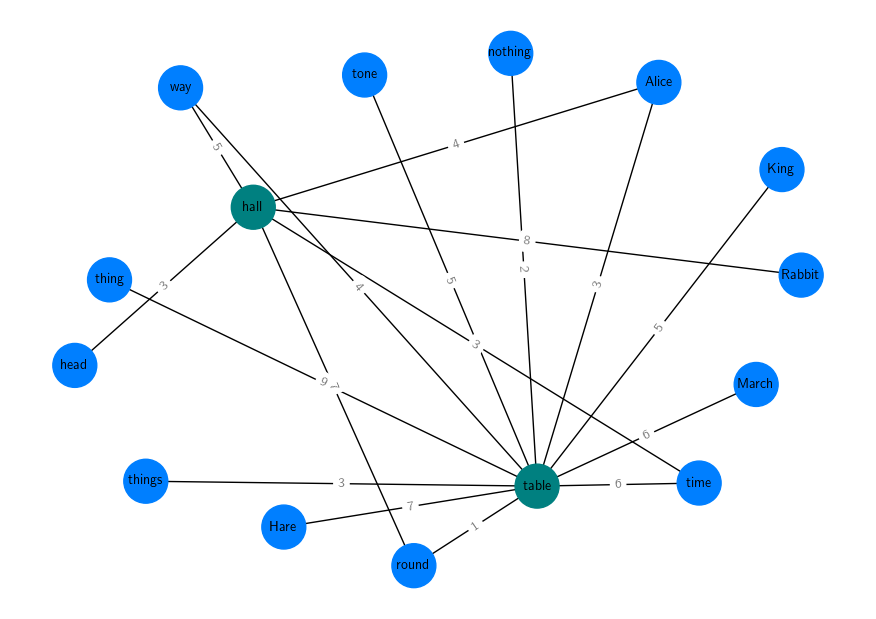

In [58]:
# Generate static graph plot from networkx

nx.draw(g_nouns, pos=pos, with_labels=True, node_size=1000, node_color=cmap, font_size=10)
plt.margins(0.1)
nx.draw_networkx_edge_labels(g_nouns, pos, edge_labels=labels, alpha=0.5)

plt.savefig("Composite_to_Basis_map_simple.pdf", bbox_inches="tight")
plt.show()

For the above data, the meanings of the composite nouns `hall` and `table` can be represented as:

$$\begin{array}{ll}
\vert \textrm{hall} \rangle &= a_0\vert \textrm{round} \rangle + a_1\vert \textrm{Rabbit} \rangle + a_2\vert \textrm{head} \rangle + a_3\vert \textrm{way} \rangle + a_4\vert \textrm{time} \rangle + a_5\vert \textrm{Alice} \rangle, \\
\vert \textrm{table} \rangle &= b_{0}\vert \textrm{March} \rangle  + b_{1}\vert \textrm{tone} \rangle  + b_{2}\vert \textrm{round} \rangle  + b_{3}\vert \textrm{nothing} \rangle  + b_{4}\vert \textrm{Hare} \rangle  + b_{5}\vert \textrm{things} \rangle  + b_{6}\vert \textrm{thing} \rangle  + b_{7}\vert \textrm{way} \rangle  + b_{8}\vert \textrm{King} \rangle  + b_{9}\vert \textrm{time} \rangle  + b_{10}\vert \textrm{Alice} \rangle,
\end{array}
$$

where we assume each item in the basis set has an orthogonal quantum state representing it. For the given 32-numbered bases, we can assume the coefficient of any unlisted state is represented as zero.

With nouns mappable to the noun basis set, and verbs mappable to the verbs basis set, we may now examine the composite noun-verb-noun sentence structures. This involves a similar approach to compositional mapping of token to token-basis, wherein composite words close together can be considered within the same NVN sentnence, and thus present themselves as a constructable entity for binary-string quantum state encoding.

The following pair-wise relations are required for a fully generalised solution:

$$
\begin{equation*}
\begin{array}{l|c|c|c}
& \textbf{Dataset 1} & \textbf{Dataset 2}  & \textbf{Use} \\
\hline
1.&\textrm{noun basis} & \textrm{noun basis} & \textrm{noun basis binary ordering} \\
2.&\textrm{noun composite} & \textrm{noun basis} & \textrm{noun representative meaning} \\
3.&\textrm{noun composite} & \textrm{noun compsite} & \textrm{inter-noun relationships} \\
\hline
4.&\textrm{verb basis} & \textrm{verb basis} & \textrm{verb basis binary ordering} \\
5.&\textrm{verb composite} & \textrm{verb basis} & \textrm{verb representative meaning} \\
6.&\textrm{verb composite} & \textrm{verb compsite} & \textrm{inter-verb relationships} \\
\hline
7.&\textrm{noun basis} & \textrm{verb basis} & \textrm{compiled bit-strings for encoding} \\
8.&\textrm{noun composite} & \textrm{verb composite} & \textrm{compositional meaning for bit-string generation} \\
\end{array}
\end{equation*}
$$

Additionally, one may add a more complex parameter exploration space by customising the tagging options; here the use of lemmatisation (mode="l"), stemming (mode="s"), or default tagging options (mode=None), results in a different set of words in the above graphs.

From here, we define our encoding and decoding dictionaries.

In [68]:
# Define basis tokens encoding and decoding dicts
encoding_dict = {"ns" : vsm.encoded_tokens["nouns"],
                 "v"  : vsm.encoded_tokens["verbs"],
                 "no" : vsm.encoded_tokens["nouns"]
                }

decoding_dict = {"ns" : { v:k for k,v in encoding_dict["ns"].items() },
                 "v"  : { v:k for k,v in encoding_dict["v"].items() },
                 "no" : { v:k for k,v in encoding_dict["no"].items() }
                }

With the above information, we can now determine the required resources to store our data in a qubit register.

In [69]:
# Register must be large enough to support 2*|nouns| + |verbs|
len_reg_memory = len(verb_dist) + 2*len(noun_dist)
len_reg_ancilla = len_reg_memory + 2
num_qubits = len_reg_memory + len_reg_ancilla
print("""{}
Requires {} qubits to encode data using {} 
basis elements in each space, allowing a 
maximum of {} unique patterns.
{}
""".format("#"*48, num_qubits, num_basis_elems, 2**num_qubits, "#"*48)
)

################################################
Requires 14 qubits to encode data using 32 
basis elements in each space, allowing a 
maximum of 16384 unique patterns.
################################################



# To be continued from here

In [66]:
################################################################################